<a href="https://colab.research.google.com/github/rafli4514/Machine-Learning/blob/voice_normalization/speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

In [5]:
!mkdir "/content/dataset/"

In [7]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset.zip" -d "/content/dataset/"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/dataset/Dataset/clips/common_voice_id_35508981.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35508983.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35508986.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35508989.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35516645.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35516646.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35516649.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35516651.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35516653.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35523487.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35523488.mp3  
  inflating: /content/dataset/Dataset/clips/common_voice_id_35523489.mp3  
  inflating: /content/dataset/Dataset/cli

In [10]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 24.0 MB/s eta 0:00:00


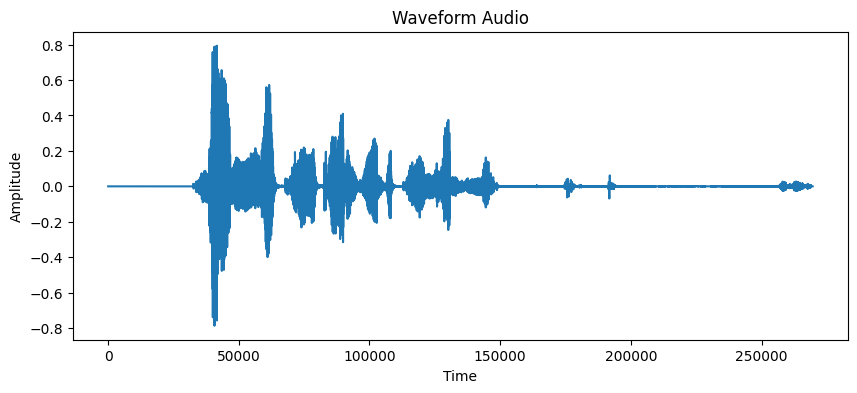

In [30]:
# Baca file audio
audio_path = "/content/dataset/Dataset/clips/common_voice_id_19051299.mp3"
audio = tf.io.read_file(audio_path)
audio_waveform = tfio.audio.decode_mp3(audio)

# Ambil satu channel audio (mono)
audio_waveform = tf.squeeze(audio_waveform, axis=-1)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_waveform.numpy())
plt.title("Waveform Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


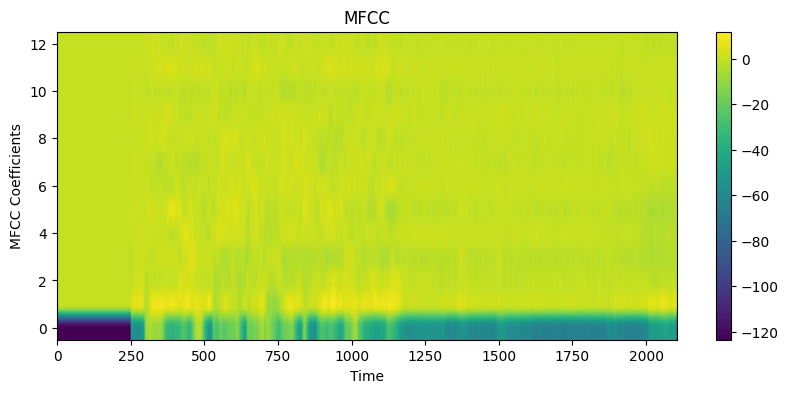

In [31]:
# Parameter STFT dan Mel
frame_length = 256
frame_step = 128
num_mel_bins = 40
num_mfccs = 13

# Ekstraksi STFT dan Mel spectrogram
stft = tf.signal.stft(audio_waveform, frame_length=frame_length, frame_step=frame_step)
spectrogram = tf.abs(stft)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000
)
mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

# Ekstraksi MFCC
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfccs]

# Plot MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


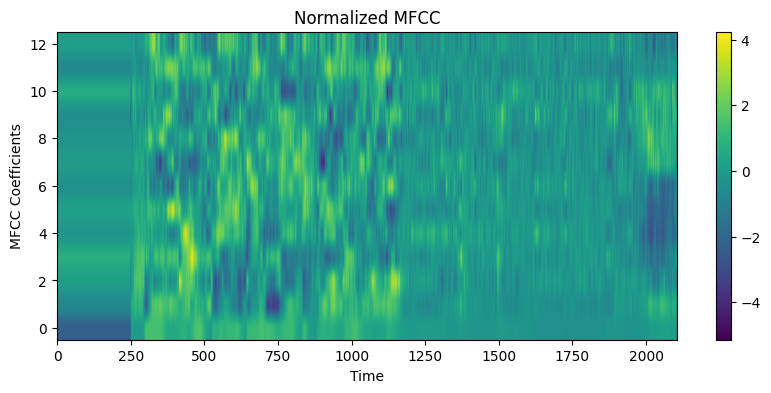

In [32]:
# Normalisasi MFCC
mean_mfcc = tf.reduce_mean(mfccs, axis=0)
std_dev_mfcc = tf.math.reduce_std(mfccs, axis=0)

# Z-score Normalization
normalized_mfccs = (mfccs - mean_mfcc) / (std_dev_mfcc + 1e-6)

# Plot MFCC yang sudah dinormalisasi
plt.figure(figsize=(10, 4))
plt.imshow(normalized_mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("Normalized MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


(269568,)


<ipython-input-33-38bcd9e7a00c>:18: RuntimeWarning: divide by zero encountered in log
  power_spec=np.log(spec)
<ipython-input-33-38bcd9e7a00c>:33: RuntimeWarning: divide by zero encountered in log
  power_spec=np.log(spec)


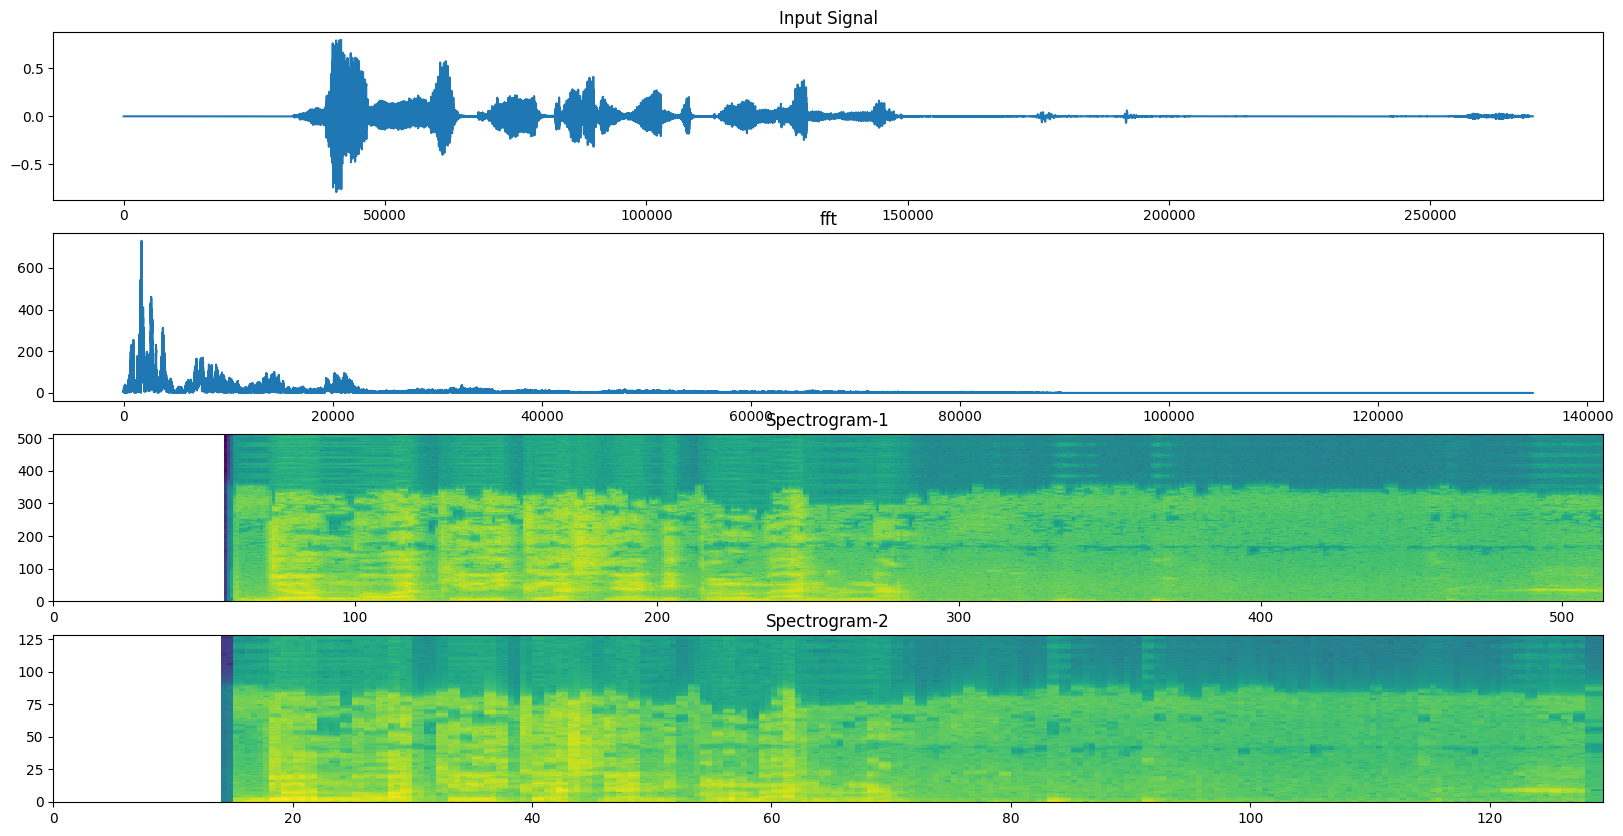

In [33]:
fig,axis = plt.subplots(4,figsize=(20,10))

L = 2000
x = tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft = tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [38]:
import csv

csv_path = "/content/dataset/Dataset/data.csv"
audio_text = {}

with open(csv_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # Lewati header
    for line in reader:
        i = line[0]  # Kolom pertama
        text = line[1]  # Kolom kedua
        audio_text[str(i)] = text

# Menampilkan beberapa data
list(audio_text.items())[:5]

[('common_voice_id_39599471.mp3', 'dia tidak sepenuhnya mempercayaiku'),
 ('common_voice_id_32165882.mp3', 'aku juga tidak mengerti'),
 ('common_voice_id_27657418.mp3', 'berharap kau di sini'),
 ('common_voice_id_23033570.mp3', 'maha suci allah'),
 ('common_voice_id_40088845.mp3',
  'pada akhirnya dia memilih anak kucing yang satunya')]

In [40]:
# list file MP3
filepaths = [filename + ".mp3" for filename in list(audio_text.keys())]

# list sentence
sentence = [text for text in audio_text.values()]

print(len(filepaths))
print(len(transcriptions))


29617
29617
